In [117]:
import joblib
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


In [4]:
path = 'dataset/archive/accepted_2007_to_2018Q4.csv'

In [23]:
sampleSize = 50000
df = pd.read_csv(path, nrows=sampleSize, low_memory=False)
# df_pee
display(df.head())

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
cols = list(df_peek.columns)
print(f"Total columns: {len(cols)}")
print(cols)

Total columns: 151
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint'

In [17]:
relevantCols = [c for c in cols if 'status' in c.lower() or 'loan' in c.lower()]
print("Target columns")
print(relevantCols)

Target columns
['loan_amnt', 'verification_status', 'loan_status', 'initial_list_status', 'verification_status_joint', 'hardship_status', 'hardship_loan_status', 'settlement_status']


In [24]:
print(df['loan_status'].value_counts())

loan_status
Fully Paid            34978
Charged Off            9027
Current                5610
Late (31-120 days)      246
In Grace Period         100
Late (16-30 days)        38
Default                   1
Name: count, dtype: int64


In [29]:
completeStatus = ["Fully Paid", "Charged Off"]

In [30]:
dfClean = df[df['loan_status'].isin(completeStatus)].copy()

In [35]:
print(dfClean['loan_status'].head())

0    Fully Paid
1    Fully Paid
2    Fully Paid
4    Fully Paid
5    Fully Paid
Name: loan_status, dtype: object


In [36]:
dfClean['target'] = (dfClean['loan_status'] == 'Charged Off').astype(int)

In [44]:
print(dfClean[['loan_status', 'target']].head())

  loan_status  target
0  Fully Paid       0
1  Fully Paid       0
2  Fully Paid       0
4  Fully Paid       0
5  Fully Paid       0


In [41]:
print("\nClass Balance:")
print(dfClean['target'].value_counts(normalize=True))


Class Balance:
target
0    0.794864
1    0.205136
Name: proportion, dtype: float64


In [46]:
missing_fractions = dfClean.isnull().mean()

In [50]:
print(missing_fractions.sort_values(ascending=False).head(10))

member_id                              1.0
sec_app_collections_12_mths_ex_med     1.0
sec_app_chargeoff_within_12_mths       1.0
sec_app_num_rev_accts                  1.0
sec_app_open_act_il                    1.0
sec_app_revol_util                     1.0
sec_app_open_acc                       1.0
next_pymnt_d                           1.0
sec_app_mths_since_last_major_derog    1.0
sec_app_earliest_cr_line               1.0
dtype: float64


In [52]:
drop_threshold = 0.5
drop_list = missing_fractions[missing_fractions > drop_threshold].index.tolist()

In [53]:
print(f"\nDropping {len(drop_list)} columns that are more than {drop_threshold*100}% empty...")


Dropping 57 columns that are more than 50.0% empty...


In [54]:
dfClean = dfClean.drop(columns=drop_list)

In [56]:
print(f"Remaining columns: {dfClean.shape[1]}")

Remaining columns: 95


In [58]:
leakage_cols = [
    'recoveries', 'collection_recovery_fee', 'total_pymnt', 
    'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
    'total_rec_late_fee', 'last_pymnt_d', 'last_pymnt_amnt'
]

In [59]:
present_leakage = [c for c in leakage_cols if c in dfClean.columns]

In [60]:
print(f"Found {len(present_leakage)} cheating columns to drop:")
print(present_leakage)

Found 9 cheating columns to drop:
['recoveries', 'collection_recovery_fee', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'last_pymnt_d', 'last_pymnt_amnt']


In [61]:
dfClean = dfClean.drop(columns=present_leakage, errors='ignore')

In [62]:
useless_cols = ['id', 'url', 'zip_code', 'policy_code']
dfClean = dfClean.drop(columns=useless_cols, errors='ignore')

In [63]:
print(f"Remaining columns after cleaning leakage: {dfClean.shape[1]}")

Remaining columns after cleaning leakage: 82


In [64]:
dfClean['term'] = dfClean['term'].astype(str).str.replace(' months', '').str.strip().astype(int)

In [65]:
emp_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

In [66]:
dfClean['emp_length'] = dfClean['emp_length'].map(emp_map)

In [69]:
print(dfClean[['term', 'emp_length']].head())
print(f"\nUnique terms: {dfClean['term'].unique()}")

   term  emp_length
0    36        10.0
1    36        10.0
2    60        10.0
4    60         3.0
5    36         4.0

Unique terms: [36 60]


In [70]:
num_cols = dfClean.select_dtypes(include=['float64', 'int64', 'int32']).columns

In [75]:
cat_cols = dfClean.select_dtypes(include=['object']).columns

In [71]:
dfClean[num_cols] = dfClean[num_cols].fillna(dfClean[num_cols].median())

In [77]:
dfClean[cat_cols] = dfClean[cat_cols].fillna("Unknown")

In [78]:
print(f"Total missing values: {dfClean.isnull().sum().sum()}")

Total missing values: 0


In [79]:
text_cols = dfClean.select_dtypes(include=['object']).columns

In [80]:
print("Unique values per text column:")
print(dfClean[text_cols].nunique().sort_values(ascending=False))

Unique values per text column:
emp_title               19101
earliest_cr_line          599
addr_state                 49
last_credit_pull_d         42
sub_grade                  35
title                      13
purpose                    12
grade                       7
home_ownership              4
verification_status         3
application_type            2
loan_status                 2
issue_d                     2
initial_list_status         2
debt_settlement_flag        2
pymnt_plan                  1
hardship_flag               1
disbursement_method         1
dtype: int64


In [81]:
columns_to_drop = [
    'emp_title', 'sub_grade', 'title',          # High cardinality / Redundant
    'earliest_cr_line', 'last_credit_pull_d',   # Dates (too complex for now)
    'issue_d',                                  # Date
    'pymnt_plan', 'hardship_flag',              # Only 1 unique value (useless)
    'disbursement_method', 
    'loan_status'                               # The original target (we have 'target' now)
]

In [82]:
dfClean = dfClean.drop(columns=columns_to_drop, errors='ignore')

In [84]:
print(f"Columns remaining: {dfClean.shape[1]}")

Columns remaining: 72


In [85]:
dfClean = pd.get_dummies(dfClean, drop_first=True)

In [86]:
print(f"Final shape for training: {dfClean.shape}")

Final shape for training: (44005, 137)


In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = dfClean.drop('target', axis=1)  # All columns except the answer
y = dfClean['target']               # Just the answer

# split the data (80% Train, 20% Test)
# random_state=42 ensures we get the same shuffle every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training the model... (this might take 30 seconds)")

# n_estimators=100 means we are building 100 little decision trees
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
print("Training with Class Weights...")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred))

Training the model... (this might take 30 seconds)
--- Results with Threshold 0.2 ---
Accuracy: 0.6442

Detailed Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74      6982
           1       0.33      0.67      0.44      1819

    accuracy                           0.64      8801
   macro avg       0.60      0.65      0.59      8801
weighted avg       0.77      0.64      0.68      8801



In [101]:


importances = model.feature_importances_
feature_names = X.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)
print(feature_df.head(10))

                 Feature  Importance
4               int_rate    0.045789
8                    dti    0.029731
33  mo_sin_old_rev_tl_op    0.026464
28        bc_open_to_buy    0.024528
3                   term    0.024450
27           avg_cur_bal    0.023892
32    mo_sin_old_il_acct    0.023486
57       tot_hi_cred_lim    0.023427
29               bc_util    0.023181
5            installment    0.023106


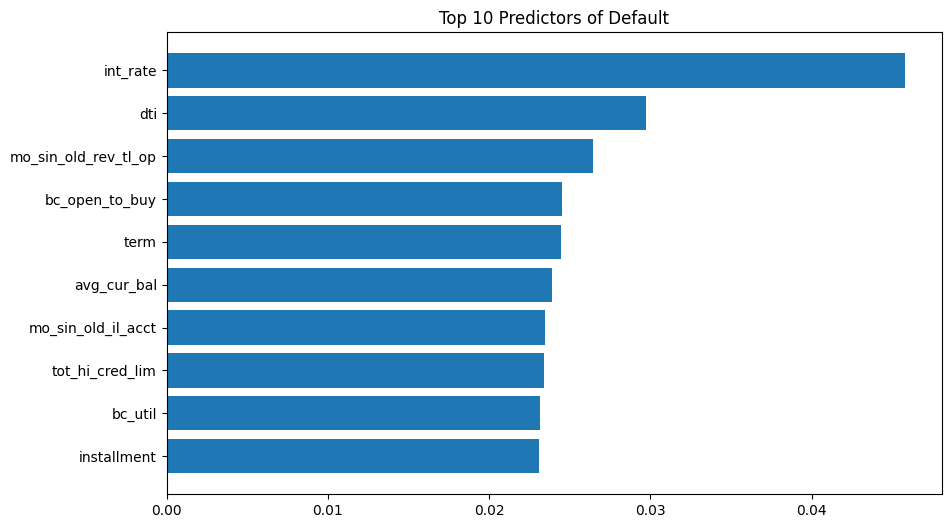

In [126]:
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'].head(10), feature_df['Importance'].head(10))
plt.gca().invert_yaxis() 
plt.title("Top 10 Predictors of Default")
plt.show()

In [97]:
new_leaks = ['last_fico_range_high', 'last_fico_range_low']

In [98]:
settlement_cols = [c for c in dfClean.columns if 'debt_settlement_flag' in c]
cols_to_drop = new_leaks + settlement_cols
dfClean = dfClean.drop(columns=cols_to_drop, errors='ignore')

In [99]:
print(f"Dropped {len(cols_to_drop)} leaking columns.")
print(f"Remaining columns: {dfClean.shape[1]}")

Dropped 3 leaking columns.
Remaining columns: 134


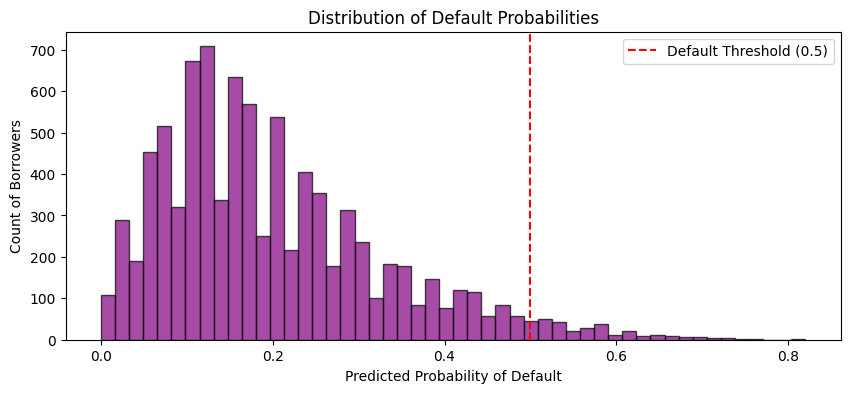

--- Results with Threshold 0.2 ---
Accuracy: 0.6442

Detailed Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74      6982
           1       0.33      0.67      0.44      1819

    accuracy                           0.64      8801
   macro avg       0.60      0.65      0.59      8801
weighted avg       0.77      0.64      0.68      8801



In [121]:

# 1. Get the raw probabilities instead of just 0/1 predictions
# This returns a matrix. [:, 1] means "give me the probability of Class 1 (Default)"
y_prob = model.predict_proba(X_test)[:, 1]

# 2. Visualize: How confident is the model usually?
plt.figure(figsize=(10, 4))
plt.hist(y_prob, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title("Distribution of Default Probabilities")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Count of Borrowers")
plt.axvline(0.5, color='red', linestyle='--', label='Default Threshold (0.5)')
plt.legend()
plt.show()
# 3. Apply a Custom Threshold (e.g., 0.20 instead of 0.50)
new_threshold = 0.20
y_pred_adjusted = (y_prob >= new_threshold).astype(int)

# 4. Check the results with the new "aggressive" logic
print(f"--- Results with Threshold {new_threshold} ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_adjusted))

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Setup Data
X = dfClean.drop('target', axis=1)
y = dfClean['target']

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training the model... (this might take 30 seconds)")

# 3. Train with Class Weights
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)


# 4. Get probabilities instead of just 0/1
# [:, 1] gets the probability of Class 1 (Default)
y_prob = model.predict_proba(X_test)[:, 1]

# 5. Apply Custom Threshold (0.20)
# If the model is at least 20% suspicious, mark it as a Default (1)
threshold = 0.20
y_pred_adjusted = (y_prob >= threshold).astype(int)

# 6. Show Results
print(f"--- Results with Threshold {threshold} ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
print("\nDetailed Report:")
print(classification_report(y_test, y_pred_adjusted))

Training the model... (this might take 30 seconds)
--- Results with Threshold 0.2 ---
Accuracy: 0.6442

Detailed Report:
              precision    recall  f1-score   support

           0       0.88      0.64      0.74      6982
           1       0.33      0.67      0.44      1819

    accuracy                           0.64      8801
   macro avg       0.60      0.65      0.59      8801
weighted avg       0.77      0.64      0.68      8801



In [124]:
print(dfClean['mo_sin_old_rev_tl_op'])

0        128.0
1        192.0
2        184.0
4        210.0
5         54.0
         ...  
49995    139.0
49996    286.0
49997     55.0
49998    291.0
49999    372.0
Name: mo_sin_old_rev_tl_op, Length: 44005, dtype: float64
